<a href="https://colab.research.google.com/github/Matig91/Colab-projects/blob/main/CS%20231n%20Convolutional%20NN%20(Stanford)/2.1_FullyConnectedNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title drive.mount
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [ ]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
# from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# Load the (preprocessed) CIFAR-10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


Summary
We looked in detail at:
TLDRs
- Activation Functions (use ReLU)
- Data Preprocessing (images: subtract mean)
- Weight Initialization (use Xavier init)
- Batch Normalization (use)
- Babysitting the Learning process
- Hyperparameter Optimization
(random sample hyperparams, in log space when appropriate)

In [ ]:
# @title UTILS (Not Current)
from builtins import range
import numpy as np
from builtins import range
import numpy as np

def affine_forward(x, w, b):
  # out = None
  N = x.shape[0]
  x_resh = x.reshape(N, -1)
  out    = np.dot(x_resh, w) + b
  cache  = (x, w, b)
  return out, cache

def affine_backward(dout, cache):
  # initial dout is usually One - then, it goes as per Chain Rule. Cache is used to make calculation
  # the case presented for Affine layer (Fully-connected layer)
  x, w, b = cache
  dx, dw, db = None, None, None
  # x  = x.reshape(x.shape[0], -1)
  x_reshaped = x.reshape(x.shape[0], -1)
  dx = (dout @ w.T).reshape(x.shape[0], *x.shape[1:])  # N x D = N x M | M x D
  dw = x_reshaped.T @ dout    # D x M = D x N | N x M
  db = np.sum(dout, axis=0)   # (M, )

  return dx, dw, db

def relu_forward(x):
    """ Computes the forward pass for a layer of rectified linear units (ReLUs).
    Input: - x: Inputs, of any shape. Returns a tuple of: - out: Output, of the same shape as x - cache: x  """
    out = None
    out = np.maximum(x, 0)
    cache = x
    return out, cache

def relu_backward1(dout, cache):
    """ Computes the backward pass for a layer of rectified linear units (ReLUs).
    Input: - dout: Upstream derivatives, of any shape; - cache: Input x, of same shape as dout;  Returns: - dx: Gradient with respect to x """
    x = cache # ; dx = None;
    # print(x.shape)

    dx = dout * (x>0)
    # dx = dout.copy(); dx[x<0] = 0
    # dx = np.where(x > 0, dout, 0)
    return dx

def softmax_loss(x, y):
  """  Computes the loss and gradient for softmax classification.
  Inputs:    - x: Input data, of shape (N, C) where x[i, j] is score for jth
    class for ith input.  - y: Vector of labels, of shape (N,) where y[i] is label for x[i] and 0 <= y[i] < C
  Returns a tuple of: - loss: Scalar giving loss; - dx: Gradient of loss with respect to x    """
  loss, dx = None, None
  N = x.shape[0]
  softmax  = np.exp(x - np.max(x,axis=1, keepdims=True))     # numerically stable exponents | Softmax = P
  softmax /= np.sum(softmax, axis=1, keepdims=True)
  loss     = -np.sum(np.log(softmax[np.arange(N), y])) / N

  softmax[np.arange(N), y] -= 1
  dx =  softmax / N
  return loss, dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """ FORWARD pass for BATCH NORMALIZATION.  During TRAINING SAMPLE mean and (UNCORRECTED)
    sample variance are computed from MINIBATCH STATISTICS and used to normalize incoming data.
    During TRAINING we also keep an EXPONENTIALLY DECAYING RUNNING AVERAGES of the
    mean and variance of each feature, and these AVERAGES ARE USED to normalize data at TEST-TIME.
    At each TIMESTEP we UPDATE RUNNING AVERAGES for mean and variance using
    an exponential decay based on MOMENTUM PARAMETER: RUNNING_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    Note that batch normalization paper suggests a DIFFERENT TEST-TIME
    behavior: they compute sample mean and variance for each feature using a
    large number of TRAINING IMAGES RATHER THAN USING A RUNNING AVERAGE. For this implementation we have chosen to use running averages
    instead since they do not require an additional estimation step; torch7 implementation of batch normalization also uses running averages.
    Input:  - x: Data of shape (N, D) - gamma: Scale parameter of shape (D,); - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with following keys:
      - mode: 'train' or 'test'; required    - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.     - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:    - out: of shape (N, D); - cache: A TUPLE of values needed in backward pass """

    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))
    out, cache = None, None

    if mode == "train":
      # TODO: Implement training-time forward pass for batch norm
      """ Use MINIBATCH STATISTICS to compute MEAN and VARIANCE, use
      these statistics to normalize INCOMING DATA, and SCALE AND SHIFT normalized data using GAMMA and BETA.
      You should store output in variable OUT. Intermediates  needed for BACKPROP – to be STORED in CACHE.
      Use computed SAMPLE mean and variance to UPDATE RUNNING mean and  running variance using MOMENTUM, storing result in running_mean/ running_var
      Note that though you should be keeping track of running  VARIANCE, you should normalize data
      based on standard DEVIATION (square root of variance) instead! (see: https://arxiv.org/abs/1502.03167) """

      # Compute output
      mu  = x.mean(axis=0)        # batch mean for each feature (axis=0, aka mean img earlier)
      var = x.var(axis=0)         # batch variance for each feature
      std = np.sqrt(var + eps)    # batch standard deviation for each feature
      xm  = x - mu
      x_hat = xm / std
      out   = x_hat * gamma + beta    # scaled and shifted x_hat

      running_mean = momentum*running_mean + (1-momentum)*mu   # Update running average of variance
      running_var  = momentum*running_var  + (1-momentum)*var

      cache = (x, x_hat, xm, std, var, eps, gamma)     # **********

    elif mode == "test":              # TODO: Implement TEST-time FWD-pass for BN.
      """ Use RUNNING mean and variance to NORMALIZE INCOMING DATA,
      then SCALE & SHIFT normalized data using GAMMA and BETA. Store result in out variable. """
      std   = np.sqrt(running_var + eps)
      x_hat = (x-running_mean) / std
      out = x_hat*gamma + beta        # Broadcasted on examples, same gamma per each feature(-wise)   #  **********
    else:
      raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"]  = running_var
    return out, cache

def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization. Write out Computation Graph for batchNorm on paper
    and propagate Gradients backward through Interm.Nodes. Inputs: - dout: Upstream derivatives, shape=(N, D);
    - cache: Intermediates var from batchnorm_forward.     Returns a tuple of: - dx: Grad w.r.t inputs x; shape=(N, D)
    - dgamma: Grad w.r.t.gamma (scale),shape=(D,);         - dbeta: Grad w.r.t shift param.beta; shape=(D,)    """
    dx, dgamma, dbeta = None, None, None
    # TODO: Backwrd pass for batchNorm-n (store results in dx, dgamma, and dbeta vars)
    # out = gamma * x_hat + beta = (N x D) x (D, 1)-> (N x D)
    x, x_hat, xm, std, var, eps, gamma = cache; N, D = dout.shape # xm = x-mu
    [gamma, dbeta] = np.atleast_2d(gamma, dbeta)
    dbeta  = dout.sum(axis=0)        # dbeta(D,) = dout/N x D/.sum(axis=0)
    dgamma = (dout * x_hat).sum(axis=0)            # dgamma(D,)= (N x D) x (N x D)
    # dgamma = dl/dg = dl/ds * ds/dg(global x local) = dout * (g * x_hat)' = dout * x_hat
    dxn = gamma * dout                                  # step 8
    dxm_l = dxn / std                                   # step 7 (left), std = ivar
    dstd = -np.sum((dxn * xm), axis=0) / (std * std)    # step 6 & 7(down)
    dvar = 0.5 * dstd / std                             # step 5
    # dxm_d = (2.0 / N) * xm * dvar                       # step 4-3
    dxm_d = 2.0 * xm /N * (np.ones((N,D)) * dvar)                 # step 4-3 (exp.)
    dmu = -np.sum(dxm_l+dxm_d, axis=0)                  # step 2 (down)
    dx  = dxm_l+dxm_d + dmu/N                           # step
    return dx, dgamma, dbeta

def batchnorm_backward_alt(dout, cache):
    """Alternative BN backward pass.  Work out derivatives on paper and simplify as much as possible toward simple expression for the backward pass.  Note: expect to receive the same cache variable. but might not use all of the values in the cache. """
    dx, dgamma, dbeta = None, None, None
    x, x_hat, xm, std, var, eps, gamma = cache
    N, D = dout.shape                               # xm = x-mu
    # TODO: Implement the backward pass for batch normalization.
    """Store the results in the dx, dgamma, and dbeta variables. After computing the gradient with respect to the centered inputs,
    you should be able to compute gradients with respect to the inputs in a single statement; our implementation fits on a single 80-character line."""
    dbeta  = dout.sum(axis=0)
    dgamma = (dout * x_hat).sum(axis=0)
    dx = (1. / N) * gamma * (var + eps)**(-1. / 2.) * (N * dout - np.sum(dout, axis=0)-xm * (var + eps)**(-1.0) * np.sum(dout * xm, axis=0))   # **********
    return dx, dgamma, dbeta

def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization. During both training and test-time, the incoming data is NORMALIZED per data-point,
    before being SCALED by gamma and beta parameters identical to that of batch normalization.
    Note that IN CONTRAST to Batch Normalization, the behavior during train VS. test-time for layer normalization are IDENTICAL,
    and we do not need to keep track of running averages of any sort.
    Input:  - x: Data of shape (N, D);  - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,);  - ln_param: Dictionary with the following keys; - eps: Constant for numeric stability
    Returns a tuple of:    - out: of shape (N, D)  - cache: A tuple of values needed in the backward pass   """
    out, cache = None, None
    eps = ln_param.get("eps", 1e-5)
    # TODO: Implement the Training-time fwd pass for layer norm. Normalize the incoming data, and scale and  shift the normalized data using gamma and beta.
    # HINT: this can be done by slightly modifying your training-time implementation of  batch normalization, and inserting a line or two of well-placed code.
    # In particular, can you think of any MATRIX TRANSFORMATIONS you could perform, that would enable you to copy over the batch norm code and leave it almost unchanged?

    mu  = x.mean(axis=1, keepdims=True)
    var = x.var(axis=1, keepdims=True)         # features variance for each feature
    std = np.sqrt(var + eps)    # features standard deviation for each feature
    x_hat = (x - mu) / std; xm = x - mu
    out   = x_hat * gamma + beta
    cache = (x, x_hat, xm, std, var, eps, gamma, mu)  # (x, mu, var, std, eps, x_hat)
    return out, cache

def layernorm_backward(dout, cache):
    """Backward pass for layer normalization. For this implementation, you can heavily rely on the work you've done already
    for batch normalization.  Inputs: - dout: Upstream derivatives, of shape (N, D); - cache: Variable of intermediates from layernorm_forward.
    Returns a tuple of: - dx: Gradient with respect to inputs x, of shape (N, D)  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)    """
    dx, dgamma, dbeta = None, None, None
    # x, mu, var, std, eps, x_hat = cache
    x, x_hat, xm, std, var, eps, gamma, mu = cache
    xm = x - mu

    # TODO: Implement the backward pass for layer norm. # HINT: this can be done by slightly
    # modifying your training-time implementation of Batch Normalization. The hints to the forward pass still apply!
    N, D = x.shape
    dbeta  = dout.sum(axis=0, keepdims=True)
    dgamma = (dout * x_hat).sum(axis=0, keepdims=True)
    dx = (1. / D) * (var + eps)**-0.5 * (D * gamma * dout - np.sum(dout* gamma, axis=1, keepdims=True) - xm * (var + eps)**(-1) * np.sum(dout*xm* gamma, axis=1, keepdims=True))

    # dxn = dout * gamma; xn =  xm * istd        #
    # dx   = dxn - dxn.mean(-1, keepdims=True) - xn * (dxn*xn).mean(-1, keepdims=True)
    # dx  *= istd

    return dx, dgamma, dbeta

In [ ]:
# @title >> FC_NET.py
from builtins import range, object
from cs231n.layer_utils import *
from cs231n.layers import *
from builtins import range
from builtins import object
import numpy as np

class FullyConnectedNet(object):
    """Class for a multi-layer fully connected NN.  Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch/layer normalization as options. For a network with L layers, the architecture will be
    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax
    where batch/layer normalization and dropout are optional and the {...} block is repeated L - 1 times.
    Learnable parameters are stored in the self.params dictionary and will be learned using the Solver class. """

    def __init__(
        self, hidden_dims,
        input_dim=3 * 32 * 32, num_classes=10,
        dropout_keep_ratio=1, normalization=None, reg=0.0, weight_scale=1e-2, dtype=np.float32, seed=None,):
        """Initialize a new FullyConnectedNet.  Inputs: - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input. - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength. If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength. - weight_scale: Scalar giving the standard deviation for random initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.     - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        # TODO: Initialize parameters of network, storing all values in
        # the SELF.PARAMS DICTIONARY. Store WEIGHTS and biases for the first layer in W1 and b1, etc.
        # Weights should be INITIALIZED FROM A NORMAL DISTRIBUTION centered at 0 with standard deviation equal to WEIGHT_SCALE.
        # BIASES should be initialized to ZERO. When using BATCH NORMALIZATION, store SCALE AND SHIFT PARAMETERS for
        # the first layer in gamma1 and beta1; for the second layer use gamma2 and
        # beta2, etc. Scale parameters should be initialized to ones and shift parameters should be initialized to zeros.

        for l, (i, j) in enumerate(zip([input_dim,*hidden_dims],[*hidden_dims, num_classes])):
          self.params[f'W{l+1}'] = weight_scale * np.random.randn(i, j)
          self.params[f'b{l+1}'] = np.zeros(j)
          if self.normalization and l < self.num_layers-1:
            self.params[f'gamma{l+1}'] = np.ones(j)
            self.params[f'beta{l+1}']  = np.zeros(j)

        # When using dropout we need to pass a dropout_param dictionary to each dropout layer, so that the layer knows the dropout probability and the mode(train/test). You can pass the same dropout_param to each dropout layer.
        # self.dropout_param = {}
        # if self.use_dropout:
        #     self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
        #     if seed is not None:
        #         self.dropout_param["seed"] = seed

        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """ Compute loss and gradient for the fully connected net.   Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k) - y: Array of labels, of shape (N,). y[i] gives the label for X[i].
        Returns:  If y is None, then run a test-time forward pass of the model and return: - scores: Array of shape (N, C) giving classification scores,
        where scores[i, c] is the classification score for X[i] and class c. If y is not None, then run a training-time forward and backward pass and return a tuple of:
        - loss: Scalar value giving the loss - grads: Dictionary with the same keys as self.params, mapping parameter names to gradients of the loss with respect to those parameters.   """
        X = X.astype(self.dtype)
        x = X
        mode = "test" if y is None else "train"
        # Set train/test mode for batchnormalization params and dropout param (behave differently during training and testing)
        # if self.use_dropout:
        #     self.dropout_param["mode"] = mode

        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode

        scores = None
        caches = []

        # TODO: Implement the forward pass for the fully connected net, computing the class scores for X and storing them in the scores variable.
        # When using dropout, you'll need to pass self.dropout_param to each dropout forward pass. When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass self.bn_params[1] to the forward pass for the second batch normalization layer, etc. gamma, bete, dropout's P
        # Forward pass through all layers except the last one        [1]
        for i in range(self.num_layers - 1):
          W, b = self.params[f'W{i+1}'], self.params[f'b{i+1}']
          x, cache_affine = affine_forward(x, W, b)                # [1.1f]
          caches.append(cache_affine)

          if self.normalization == "batchnorm":                    # [1.2f]
            x, cache_bn = batchnorm_forward(x, self.params[f"gamma{i+1}"], self.params[f"beta{i+1}"], self.bn_params[i])
            caches.append(cache_bn)

          x, cache_relu = relu_forward(x)                          # [1.3f]
          caches.append(cache_relu)

        # Forward pass through the last layer (no ReLU after this)
        W, b = self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}']
        scores, cache_last = affine_forward(x, W, b)               # [2.0f]
        caches.append(cache_last)

        # If y is None, we are in test mode so just return scores
        if y is None:
          del caches
          return scores           # test mode

        # Compute loss and gradients
        loss, grads = 0.0, {}
        loss, dscores = softmax_loss(scores, y)

        # edge layers
        dx, dw, db = affine_backward(dscores, caches.pop())       # FC backward   # [2.0bw]
        grads[f"W{self.num_layers}"] = dw + self.reg * self.params[f"W{self.num_layers}"]
        # make sure that W above is exactly self.params[f"W{self.num_layers+1}"]
        grads[f"b{self.num_layers}"] = db
        loss += 0.5*self.reg * np.sum(self.params[f"W{self.num_layers}"]**2)

        for i in range(self.num_layers - 2, -1, -1):    # self.num_layers - done above, starting from (self.num_layers-1)
          loss += 0.5*self.reg * np.sum(self.params[f"W{i+1}"]**2)
          dx         = relu_backward(dx, caches.pop())       # ReLU backward    # [1.3bw]

          if self.normalization == "batchnorm":              # BN backward.     # [1.2bw]
            dx, grads[f"gamma{i+1}"], grads[f"beta{i+1}"] = batchnorm_backward(dx, caches.pop())
          dx, dw, db = affine_backward(dx, caches.pop())            # FC backward # [1.1bw]
          grads[f"W{i+1}"] = dw + self.params[f"W{i+1}"] * self.reg
          grads[f"b{i+1}"] = db

        del caches
        return loss, grads

## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [ ]:
np.random.seed(231) # COMMENTED AS THIS RUNS OVER ENTIRE DATASET
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0.0, 3.14]:
  print("Running check with reg = ", reg)
  model = FullyConnectedNet(
      [H1, H2],
      input_dim=D,
      num_classes=C,
      reg=reg,
      weight_scale=5e-2,
      dtype=np.float64)

  loss, grads = model.loss(X, y)
  print("Initial loss: ", loss)

  # Most of the errors -  order of e-7 or smaller (error for W2 on the order of e-5 if reg = 0.0)

  for name in sorted(grads):
      f = lambda _: model.loss(X, y)[0]
      grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
      print(f"{name} relative error: {rel_error(grad_num, grads [name])}")

Running check with reg =  0.0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.409028728052923e-08
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.131129859578198e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

In [ ]:
num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

(Iteration 1 / 40) loss: 2.540213
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.113000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.115000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.117000
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.150000
(Epoch 4 / 20) train acc: 0.860000; val_acc: 0.148000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.149000
(Iteration 11 / 40) loss: 0.504525
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.188000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.162000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.172000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.176000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.188000
(Iteration 21 / 40) loss: 0.061401
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.187000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.191000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.188000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.188000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.184000
(Iteration 31 / 40) loss: 

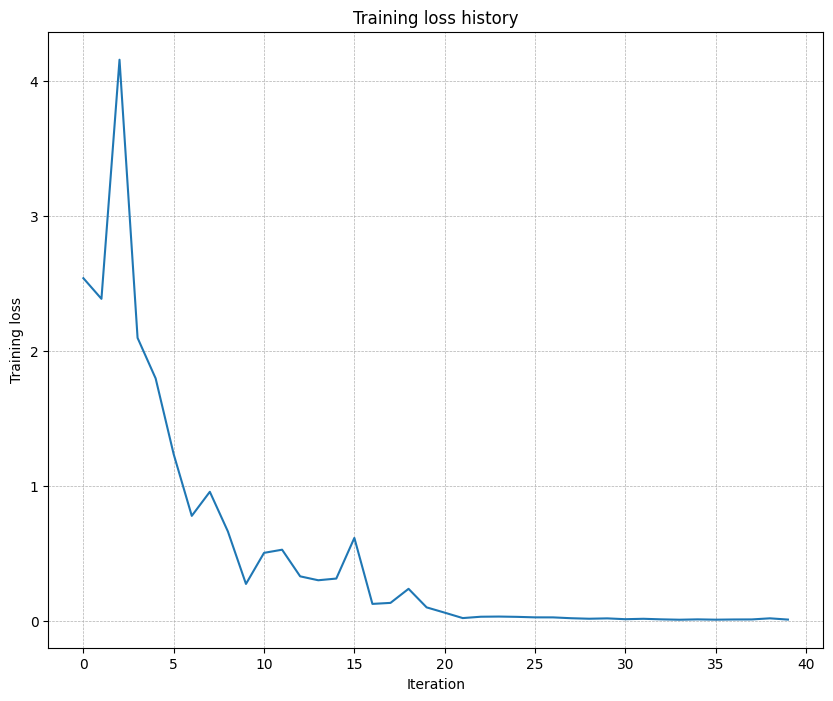

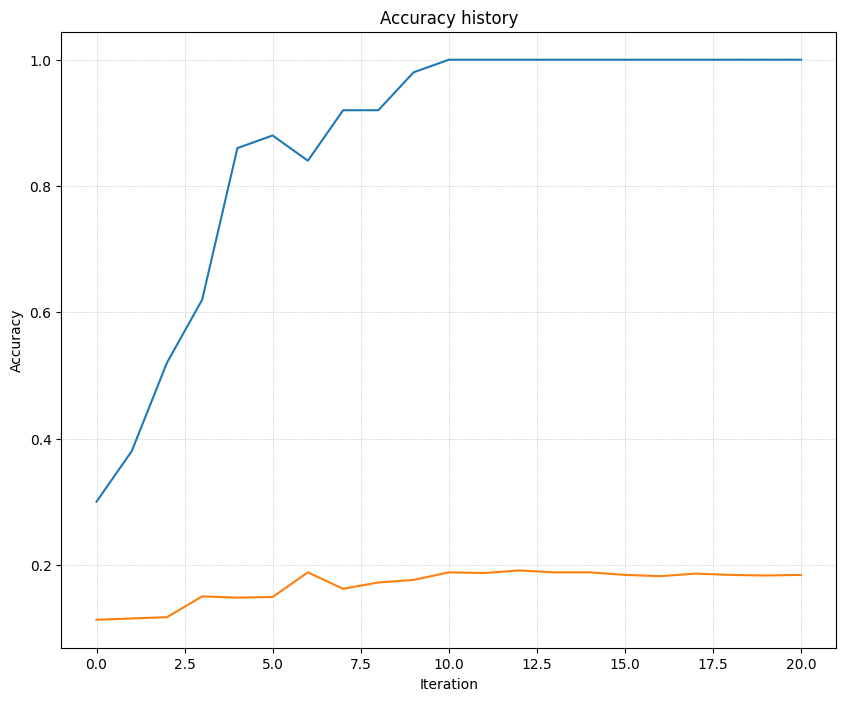

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by tweaking just the learning rate and initialization scale

weight_scale  = 2e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!

model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float32
)

solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

plt.plot(solver.train_acc_history)
plt.plot(solver.val_acc_history)
plt.title("Accuracy history")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(linestyle=':', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 80) loss: 2.839886
(Epoch 0 / 40) train acc: 0.240000; val_acc: 0.116000
(Epoch 1 / 40) train acc: 0.240000; val_acc: 0.082000
(Epoch 2 / 40) train acc: 0.360000; val_acc: 0.133000
(Epoch 3 / 40) train acc: 0.500000; val_acc: 0.124000
(Epoch 4 / 40) train acc: 0.680000; val_acc: 0.149000
(Epoch 5 / 40) train acc: 0.760000; val_acc: 0.136000
(Epoch 6 / 40) train acc: 0.800000; val_acc: 0.154000
(Epoch 7 / 40) train acc: 0.840000; val_acc: 0.171000
(Epoch 8 / 40) train acc: 0.920000; val_acc: 0.165000
(Epoch 9 / 40) train acc: 0.920000; val_acc: 0.165000
(Epoch 10 / 40) train acc: 0.940000; val_acc: 0.185000
(Iteration 21 / 80) loss: 0.427997
(Epoch 11 / 40) train acc: 1.000000; val_acc: 0.167000
(Epoch 12 / 40) train acc: 1.000000; val_acc: 0.181000
(Epoch 13 / 40) train acc: 0.980000; val_acc: 0.169000
(Epoch 14 / 40) train acc: 1.000000; val_acc: 0.170000
(Epoch 15 / 40) train acc: 1.000000; val_acc: 0.177000
(Epoch 16 / 40) train acc: 1.000000; val_acc: 0.177000
(Epoch

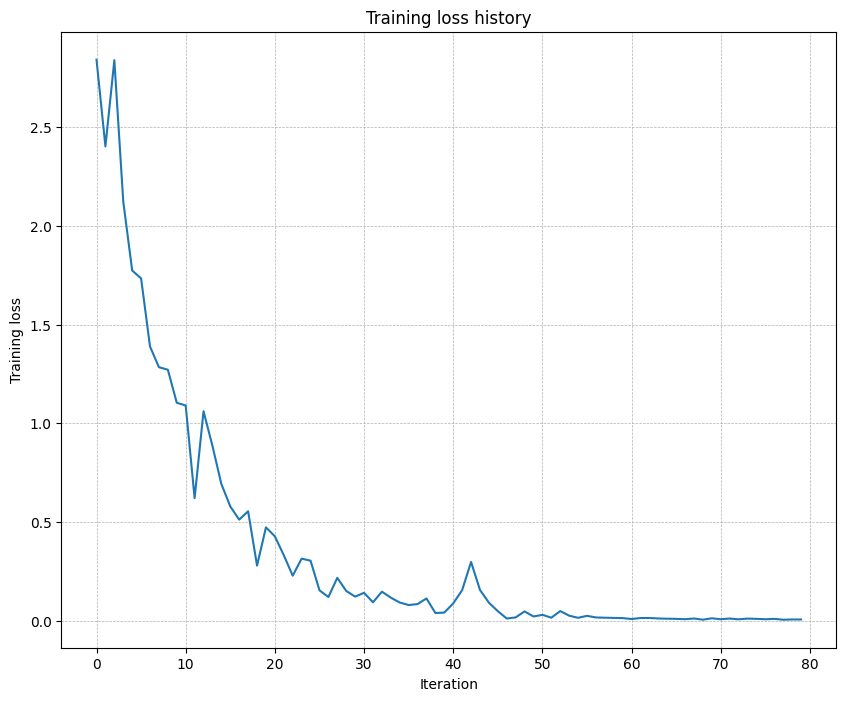

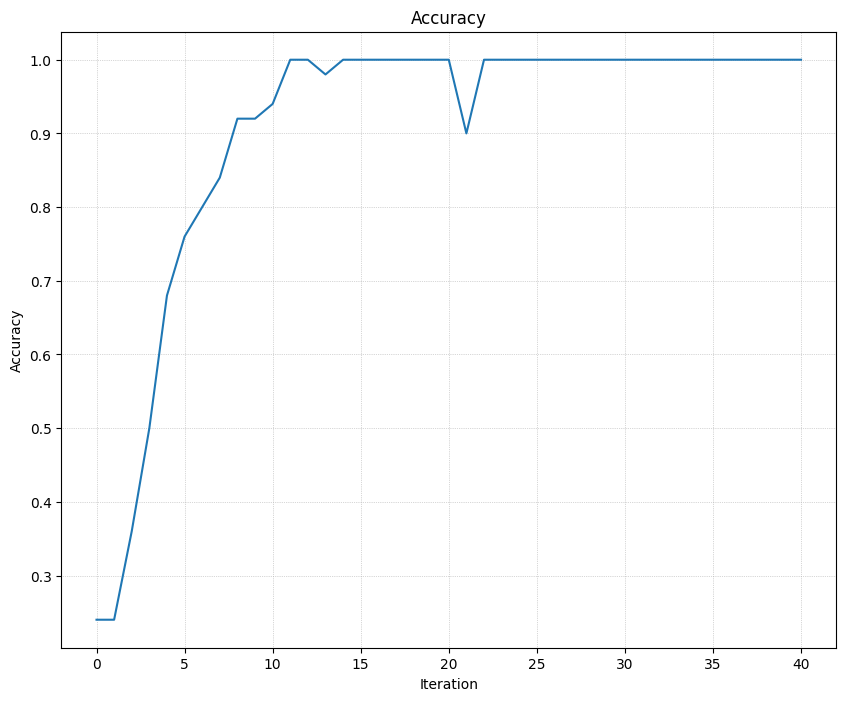

2.6927666664123535

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.
import time; start_time = time.time()

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1.5e-2    # Experiment with this!
weight_scale = 4e-2  #Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=20,
    num_epochs=40,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)

solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

plt.plot(solver.train_acc_history)
plt.title("Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(linestyle=':', linewidth=0.5)
plt.show()
time.time() - start_time

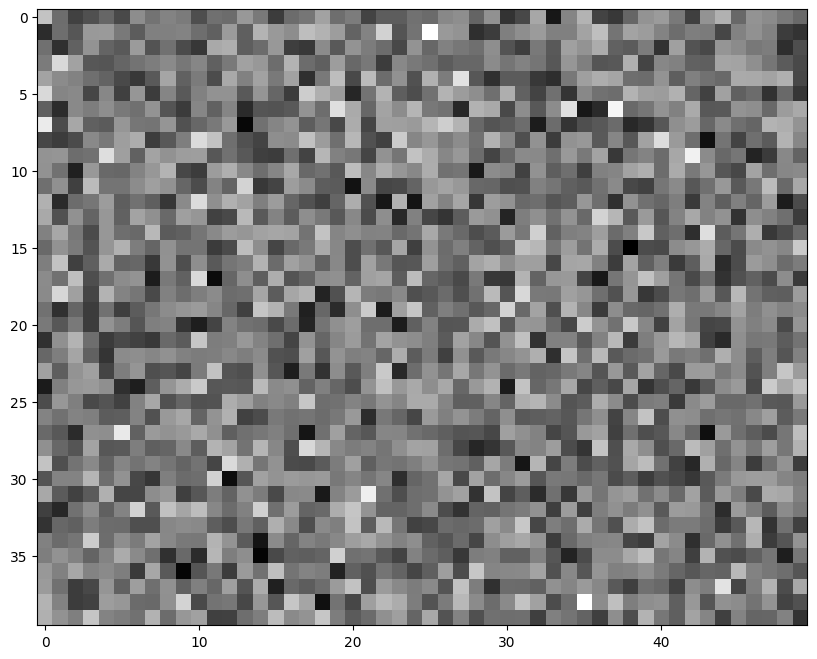

In [ ]:
plt.imshow(model.params['W1'][:20].reshape(40,-1))

## Inline Question 1:
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

cs231n/optim.py implements various first-order update rules that are commonly used for training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not
perform well; however the default values of the other hyperparameters should
work well for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.

In [ ]:
# @title cs231n/optim.py --> Copy of API-file (1/2)
import numpy as np

def sgd(w, dw, config=None):
    """ Performs vanilla stochastic gradient descent. config format:  - learning_rate: Scalar learning rate. """
    if config is None: config = {}
    config.setdefault("learning_rate", 1e-2)
    w -= config["learning_rate"] * dw
    return w, config

def sgd_momentum(w, dw, config=None):
    """Performs stochastic gradient descent with momentum. config format:   - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.  Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving average of the gradients.    """
    if config is None: config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))
    next_w = None
    # TODO: Implement the momentum update formula. Store the updated value in the next_w variable. You should also use and update the velocity v.     #
    mu = config["momentum"]
    v = mu * v - config["learning_rate"] * dw
    next_w = w + v
    config["velocity"] = v
    return next_w, config

def rmsprop(w, dw, config=None):
    """ Uses the RMSProp update rule, which uses a moving average of squared gradient values to set adaptive per-parameter learning rates. config format:
    - learning_rate: Scalar lr. - decay_rate: Scalar between 0 and 1 giving decay rate for squared
      gradient cache.    - epsilon: Small scalar used for smoothing to avoid dividing by zero.  - cache: Moving average of second moments of gradients.    """
    if config is None: config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", np.zeros_like(w))
    next_w = None
    # TODO: Implement the RMSprop update formula, storing the next value of w in the next_w variable. Don't forget to update cache value stored in config['cache']
    config["cache"]  = config["decay_rate"] * config["cache"] + (1-config["decay_rate"]) * dw**2
    next_w = w - config["learning_rate"] *dw / (np.sqrt(config["cache"]) + config['epsilon'])
    return next_w, config

In [ ]:
# from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

In [ ]:
def round_to_n_decimal_places(x, n):
    return round(x * (10 ** n)) / (10 ** n)

def calculate_rounding_error(numbers, n):
    results = []
    for num in numbers:
        rounded_num = round_to_n_decimal_places(num, n)
        error = abs(num - rounded_num)
        results.append((num, rounded_num, error))
    return results

# List of numbers to analyze
numbers = [
    1.234567,  # Close to integer
    1.999999,  # Close to integer
    2.000001,  # Close to integer
    0.123456,  # Not close to integer
    0.999999,  # Close to integer
    3.14159265358979323846,  # Pi
    2.71828182845904523536,  # e
    0.1,       # Simple decimal
    0.333333,  # Repeating decimal
]

# Specify number of decimal places
n = 1

# Calculate rounding errors
results = calculate_rounding_error(numbers, n)

# Display results
print(f"{'Original':<15} {'Rounded':<15} {'Error':<15}")
for original, rounded, error in results:
    print(f"{original:<15} {rounded:<15} {error:<15}")


Original        Rounded         Error          
1.234567        1.2             0.034567000000000014
1.999999        2.0             9.999999999177334e-07
2.000001        2.0             1.000000000139778e-06
0.123456        0.1             0.02345599999999999
0.999999        1.0             1.0000000000287557e-06
3.141592653589793 3.1             0.04159265358979303
2.718281828459045 2.7             0.018281828459044913
0.1             0.1             0.0            
0.333333        0.3             0.033333       


Running with  sgd
(Iteration 1 / 200) loss: 2.687523
(Epoch 0 / 5) train acc: 0.113000; val_acc: 0.124000
(Iteration 11 / 200) loss: 2.260495
(Iteration 21 / 200) loss: 2.263929
(Iteration 31 / 200) loss: 2.124412
(Epoch 1 / 5) train acc: 0.240000; val_acc: 0.229000
(Iteration 41 / 200) loss: 2.265384
(Iteration 51 / 200) loss: 2.115150
(Iteration 61 / 200) loss: 2.126485
(Iteration 71 / 200) loss: 2.159606
(Epoch 2 / 5) train acc: 0.317000; val_acc: 0.264000
(Iteration 81 / 200) loss: 1.985305
(Iteration 91 / 200) loss: 1.981938
(Iteration 101 / 200) loss: 1.948124
(Iteration 111 / 200) loss: 2.002448
(Epoch 3 / 5) train acc: 0.335000; val_acc: 0.269000
(Iteration 121 / 200) loss: 1.915221
(Iteration 131 / 200) loss: 1.877734
(Iteration 141 / 200) loss: 1.869148
(Iteration 151 / 200) loss: 1.821577
(Epoch 4 / 5) train acc: 0.343000; val_acc: 0.307000
(Iteration 161 / 200) loss: 1.879686
(Iteration 171 / 200) loss: 1.780551
(Iteration 181 / 200) loss: 1.927158
(Iteration 191 / 200) los

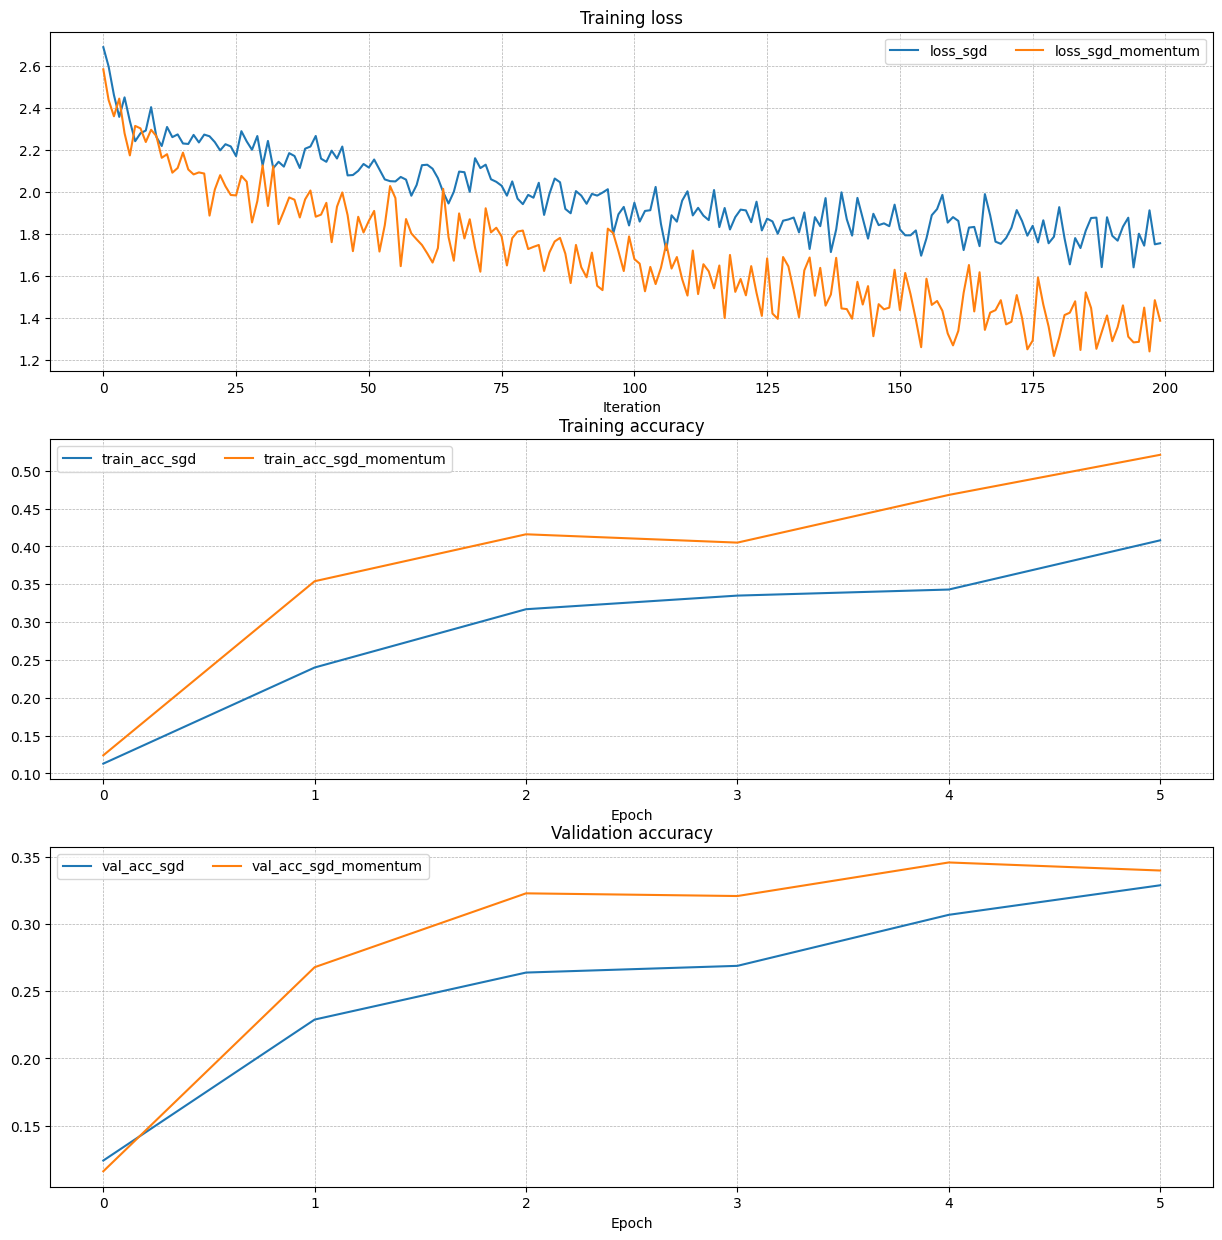

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

Running with  sgd
(Iteration 1 / 200) loss: 2.732801
(Epoch 0 / 5) train acc: 0.113000; val_acc: 0.100000
(Iteration 11 / 200) loss: 2.278844
(Iteration 21 / 200) loss: 2.150532
(Iteration 31 / 200) loss: 2.120340
(Epoch 1 / 5) train acc: 0.232000; val_acc: 0.229000
(Iteration 41 / 200) loss: 2.171567
(Iteration 51 / 200) loss: 2.079667
(Iteration 61 / 200) loss: 2.081444
(Iteration 71 / 200) loss: 1.984750
(Epoch 2 / 5) train acc: 0.295000; val_acc: 0.249000
(Iteration 81 / 200) loss: 2.145041
(Iteration 91 / 200) loss: 1.890238
(Iteration 101 / 200) loss: 1.990277
(Iteration 111 / 200) loss: 1.827562
(Epoch 3 / 5) train acc: 0.338000; val_acc: 0.275000
(Iteration 121 / 200) loss: 1.943083
(Iteration 131 / 200) loss: 1.807002
(Iteration 141 / 200) loss: 1.889175
(Iteration 151 / 200) loss: 1.865076
(Epoch 4 / 5) train acc: 0.317000; val_acc: 0.292000
(Iteration 161 / 200) loss: 1.917868
(Iteration 171 / 200) loss: 1.892803
(Iteration 181 / 200) loss: 1.880638
(Iteration 191 / 200) los

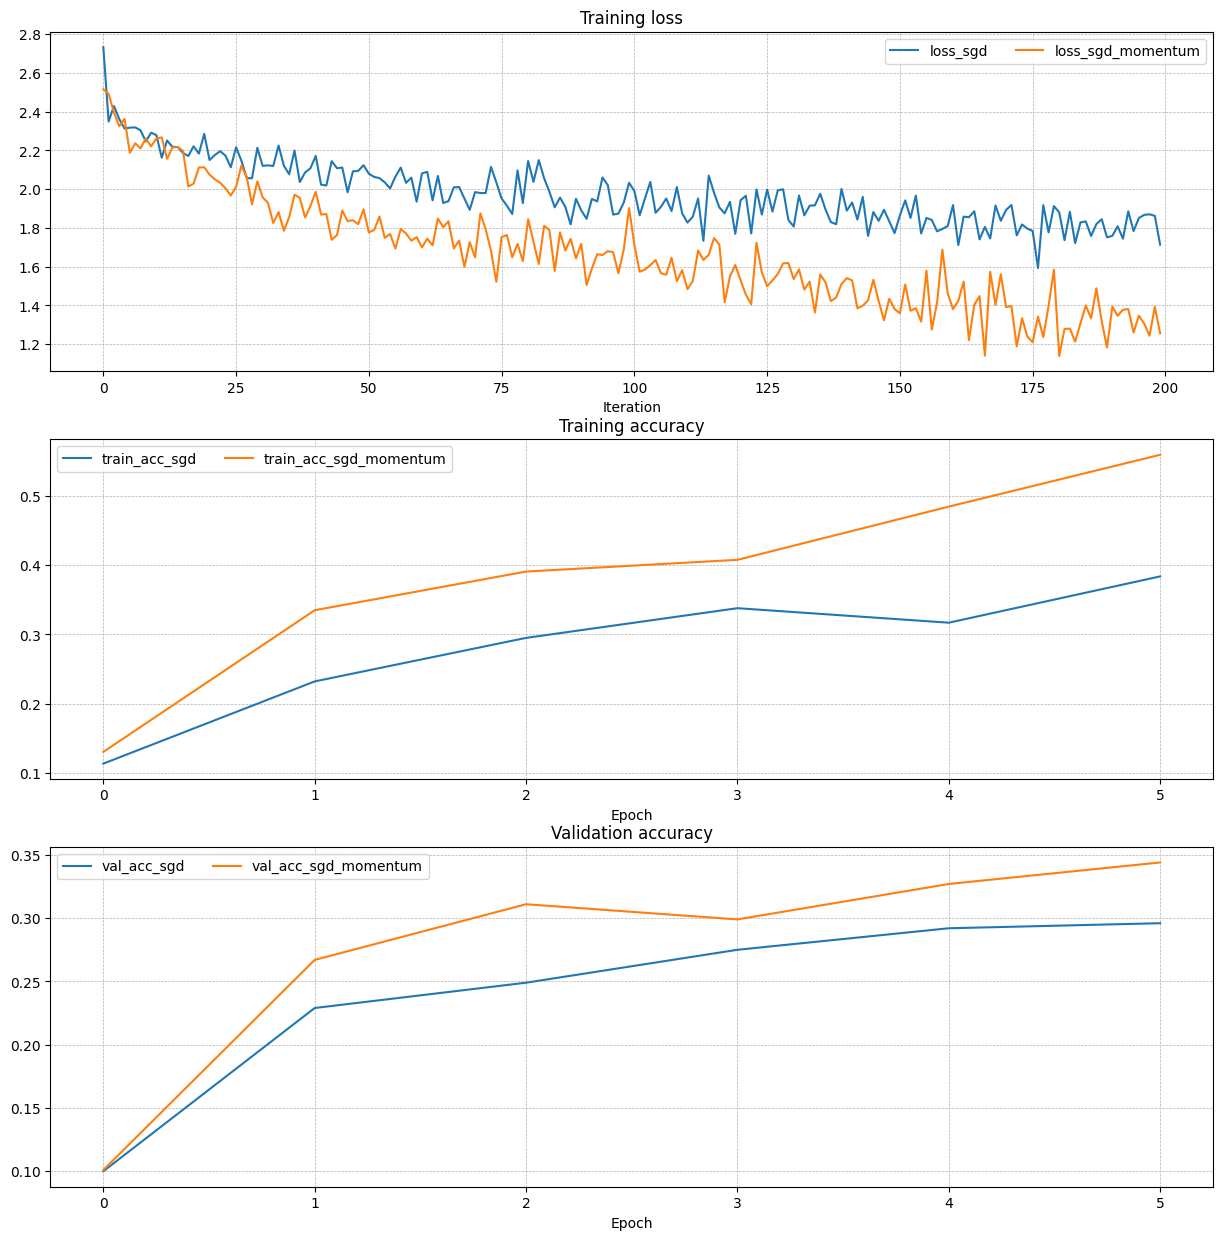

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# @title cs231n/optim.py --> Copy of API-file (2/2)

def rmsprop(w, dw, config=None):
    """ Uses the RMSProp update rule, which uses a moving average of squared gradient values to set adaptive per-parameter learning rates. config format:
    - learning_rate: Scalar lr. - decay_rate: Scalar between 0 and 1 giving decay rate for squared
      gradient cache.    - epsilon: Small scalar used for smoothing to avoid dividing by zero.  - cache: Moving average of second moments of gradients.    """
    if config is None: config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", np.zeros_like(w))
    next_w = None
    # TODO: Implement the RMSprop update formula, storing the next value of w in the next_w variable. Don't forget to update cache value stored in config['cache']
    config["cache"]  = config["decay_rate"] * config["cache"] + (1-config["decay_rate"]) * dw**2
    next_w = w - config["learning_rate"] *dw / (np.sqrt(config["cache"]) + config['epsilon'])
    return next_w, config

def adam(w, dw, config=None):
    """  Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term. config format:
    - learning_rate: Scalar learning rate. - beta1: Decay rate for moving average of 1st moment of gradient.
    - beta2: Decay rate for moving avg of grad's 2nd moment. - eps: Small scalar for smoothing (avoid dividing by zero).
    - m: Moving average of gradient. - v: Moving average of squared gradient.    - t: Iteration number.    """
    if config is None: config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9);  config.setdefault("beta2", 0.999)
    config.setdefault("m", np.zeros_like(w))
    config.setdefault("v", np.zeros_like(w))
    config.setdefault("t", 1000);        config.setdefault("epsilon", 1e-8)
    next_w = 0

    # TODO: Implement Adam update, storing the next value OF w in NEXT_W variable. Update the m, v, t - stored in CONFIG.

    config['t'] += 1 #       NOTE: In order to match reference output, modify t BEFORE using it in any calculations                                           #
    config['m'] = config['beta1']*config['m'] + (1-config['beta1'])*dw        # momentum 1 part + m-update to store
    config['v'] = config['beta2']*config['v'] + (1-config['beta2'])*(dw**2)   # momentum 2 part + v-update to store

    mb = config['m'] / (1-config['beta1']**config['t'])
    vb = config['v'] / (1-config['beta2']**config['t'])

    next_w = w - mb*config["learning_rate"]/(np.sqrt(vb)+config["epsilon"])
    return next_w, config

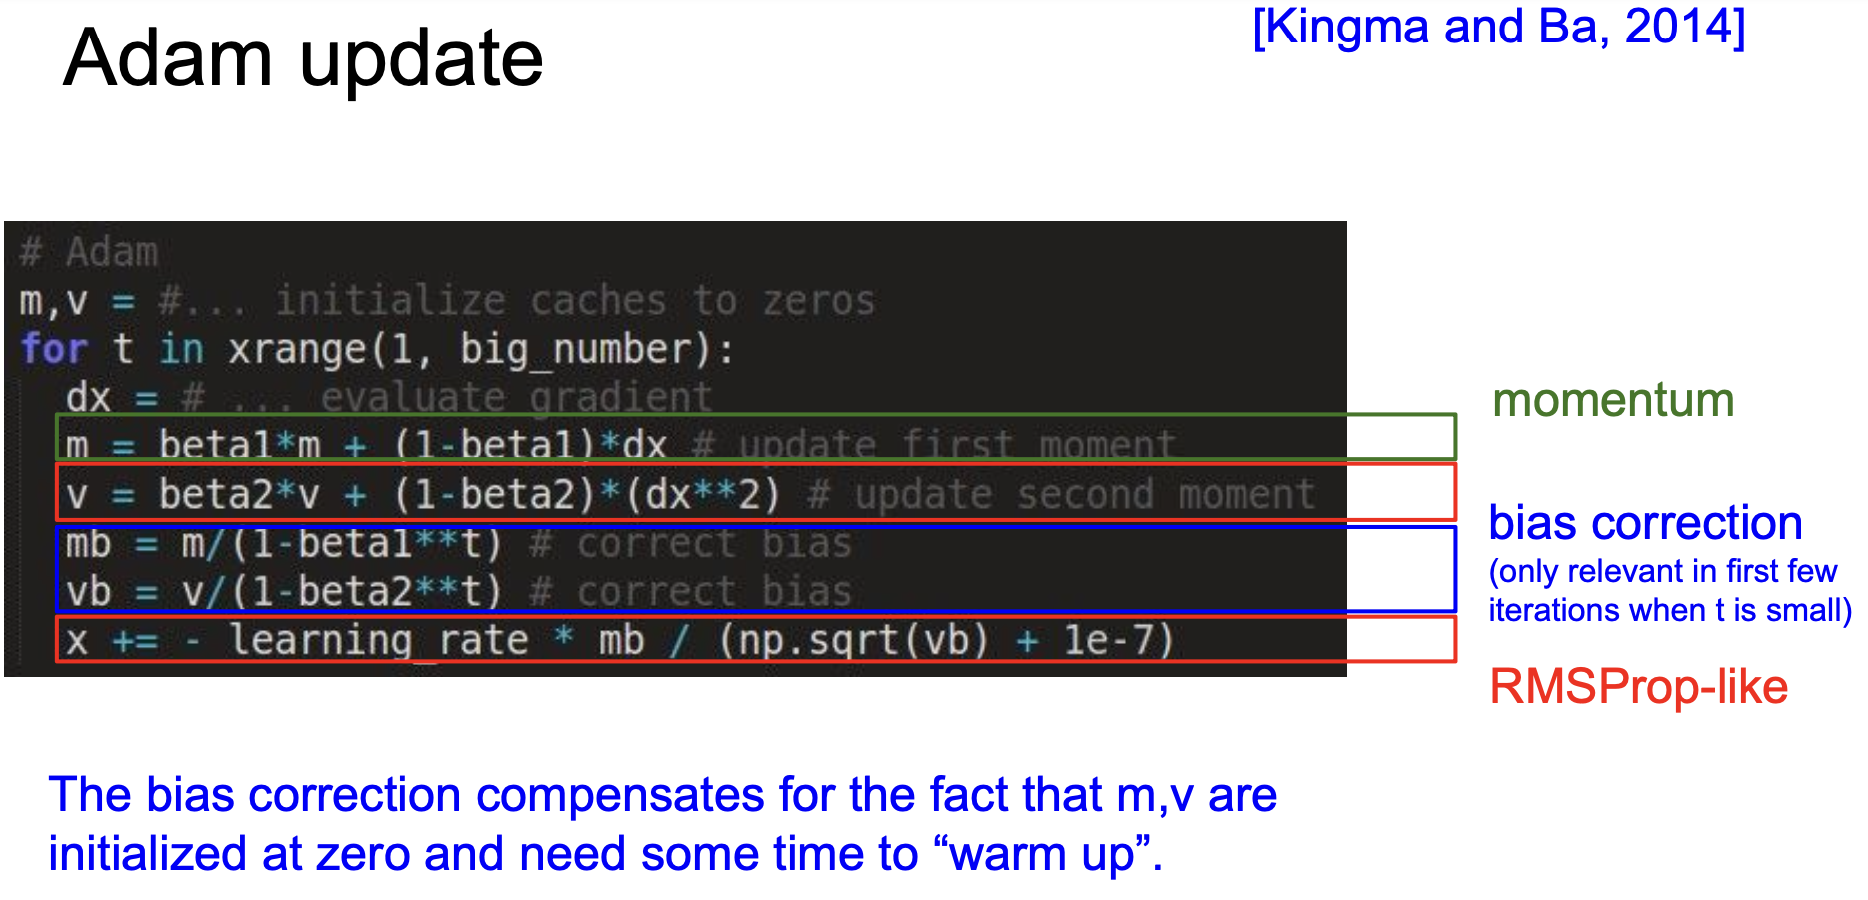
Lecture 6 - 37 (2016)

In [ ]:
#@title Test Adam implementation
# from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))
print("\n\n", config)

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


 {'learning_rate': 0.01, 'm': array([[0.48      , 0.49947368, 0.51894737, 0.53842105, 0.55789474],
       [0.57736842, 0.59684211, 0.61631579, 0.63578947, 0.65526316],
       [0.67473684, 0.69421053, 0.71368421, 0.73315789, 0.75263158],
       [0.77210526, 0.79157895, 0.81105263, 0.83052632, 0.85      ]]), 'v': array([[0.69966   , 0.68908382, 0.67851319, 0.66794809, 0.65738853],
       [0.64683452, 0.63628604, 0.6257431 , 0.61520571, 0.60467385],
       [0.59414753, 0.58362676, 0.57311152, 0.56260183, 0.55209767],
       [0.54159906, 0.53110598, 0.52061845, 0.51013645, 0.49966   ]]), 't': 6, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}


In [ ]:
#@title Test RMSProp implementation
# from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 3.016008
(Epoch 0 / 5) train acc: 0.102000; val_acc: 0.079000
(Iteration 11 / 200) loss: 2.069371
(Iteration 21 / 200) loss: 1.982511
(Iteration 31 / 200) loss: 1.961079
(Epoch 1 / 5) train acc: 0.296000; val_acc: 0.260000
(Iteration 41 / 200) loss: 1.935985
(Iteration 51 / 200) loss: 1.810006
(Iteration 61 / 200) loss: 2.000982
(Iteration 71 / 200) loss: 1.837097
(Epoch 2 / 5) train acc: 0.344000; val_acc: 0.326000
(Iteration 81 / 200) loss: 1.857475
(Iteration 91 / 200) loss: 1.712700
(Iteration 101 / 200) loss: 1.590594
(Iteration 111 / 200) loss: 1.708306
(Epoch 3 / 5) train acc: 0.381000; val_acc: 0.332000
(Iteration 121 / 200) loss: 1.898203
(Iteration 131 / 200) loss: 1.872289
(Iteration 141 / 200) loss: 1.699588
(Iteration 151 / 200) loss: 1.583854
(Epoch 4 / 5) train acc: 0.428000; val_acc: 0.365000
(Iteration 161 / 200) loss: 1.368815
(Iteration 171 / 200) loss: 1.430660
(Iteration 181 / 200) loss: 1.552569
(Iteration 191 / 200) lo

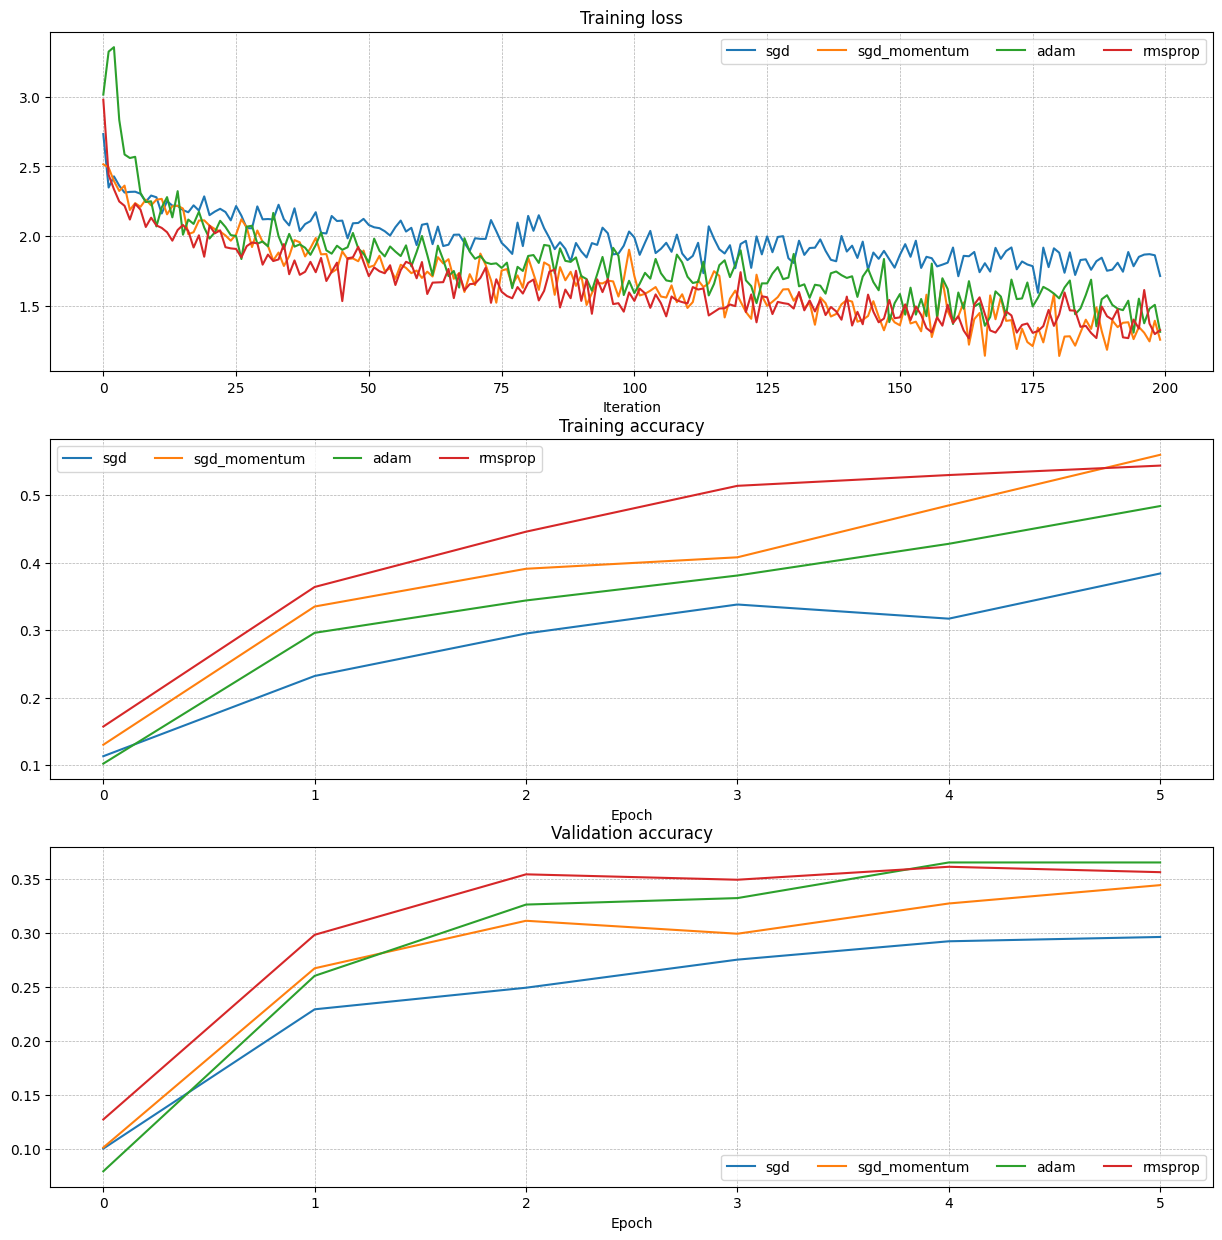

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
[FILL THIS IN]


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
learning_rates = np.logspace(-3.4, -2, 4)
weight_scales  = np.logspace(  -2, -1.6, 4)

learning_rates, weight_scales, learning_rates[1]/learning_rates[0], weight_scales[1]/weight_scales[0],

(array([0.00039811, 0.00116591, 0.00341455, 0.01      ]),
 array([0.01      , 0.01359356, 0.0184785 , 0.02511886]),
 np.float64(2.928644564625237),
 np.float64(1.3593563908785256))

In [ ]:
num_train = 5000
some_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}



(Iteration 1 / 100) loss: 2.300988
(Epoch 0 / 2) train acc: 0.132000; val_acc: 0.110000
(Iteration 11 / 100) loss: 2.295328
(Iteration 21 / 100) loss: 2.269477
(Iteration 31 / 100) loss: 2.279067
(Iteration 41 / 100) loss: 2.263704
(Epoch 1 / 2) train acc: 0.163000; val_acc: 0.149000
(Iteration 51 / 100) loss: 2.268136
(Iteration 61 / 100) loss: 2.275274
(Iteration 71 / 100) loss: 2.246660
(Iteration 81 / 100) loss: 2.247516
(Iteration 91 / 100) loss: 2.236056
(Epoch 2 / 2) train acc: 0.192000; val_acc: 0.176000


(Iteration 1 / 100) loss: 2.579610
(Epoch 0 / 2) train acc: 0.082000; val_acc: 0.090000
(Iteration 11 / 100) loss: 2.545681
(Iteration 21 / 100) loss: 2.333983
(Iteration 31 / 100) loss: 2.349833
(Iteration 41 / 100) loss: 2.401419
(Epoch 1 / 2) train acc: 0.155000; val_acc: 0.148000
(Iteration 51 / 100) loss: 2.301386
(Iteration 61 / 100) loss: 2.269056
(Iteration 71 / 100) loss: 2.342585
(Iteration 81 / 100) loss: 2.236097
(Iteration 91 / 100) loss: 2.323212
(Epoch 2 / 2)

/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/layers.py:53: RuntimeWarning: divide by zero encountered in log
  loss     = -np.sum(np.log(softmax[np.arange(N), y])) / N


(Epoch 0 / 2) train acc: 0.098000; val_acc: 0.110000
(Iteration 11 / 100) loss: 92.474019
(Iteration 21 / 100) loss: 90.948173
(Iteration 31 / 100) loss: 84.294900
(Iteration 41 / 100) loss: 71.378041
(Epoch 1 / 2) train acc: 0.137000; val_acc: 0.128000
(Iteration 51 / 100) loss: 84.622520
(Iteration 61 / 100) loss: 77.954264
(Iteration 71 / 100) loss: 62.080850
(Iteration 81 / 100) loss: 62.911168
(Iteration 91 / 100) loss: 66.160552
(Epoch 2 / 2) train acc: 0.132000; val_acc: 0.130000


(Iteration 1 / 100) loss: 2.313887
(Epoch 0 / 2) train acc: 0.079000; val_acc: 0.098000
(Iteration 11 / 100) loss: 2.267695
(Iteration 21 / 100) loss: 2.239337
(Iteration 31 / 100) loss: 2.208079
(Iteration 41 / 100) loss: 2.082978
(Epoch 1 / 2) train acc: 0.281000; val_acc: 0.275000
(Iteration 51 / 100) loss: 2.086979
(Iteration 61 / 100) loss: 2.077407
(Iteration 71 / 100) loss: 2.057241
(Iteration 81 / 100) loss: 2.007780
(Iteration 91 / 100) loss: 1.799275
(Epoch 2 / 2) train acc: 0.364000; val_ac

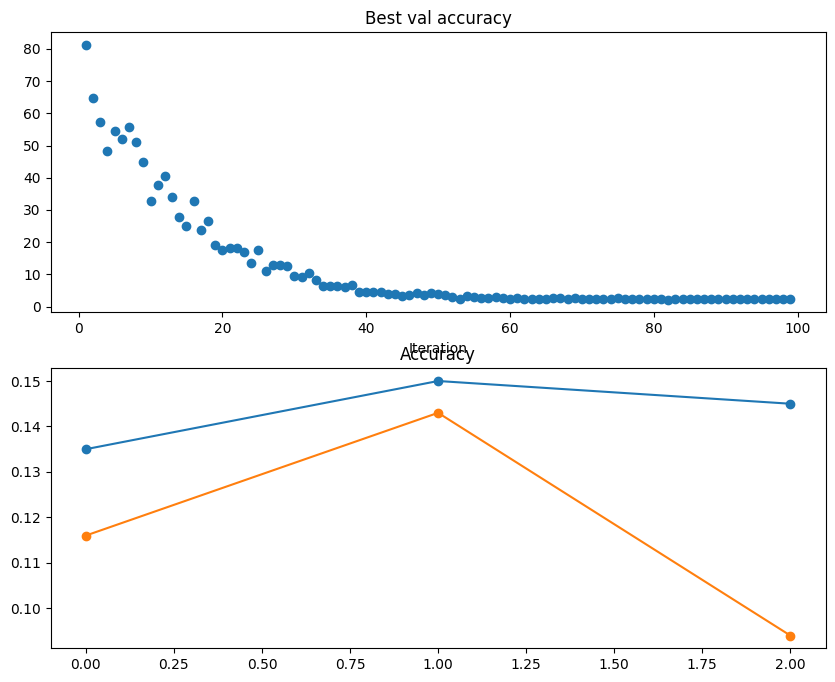

In [ ]:
from ml_dtypes import bfloat16
import numpy as np

best_model = None

# TODO: Train the best FullyConnectedNet that you can on CIFAR-10.
# You might find batch/layer-norm and dropout useful. Store best model at best_model variable                                                     #
results = {}      # results[(lr, reg)] = val_accuracy
best_val = -1

learning_rates = np.logspace(-5.5, -3, 4)
weight_scales  = np.logspace( -1.75, -1, 4)

# FullyConnectedNet(hidden_dims, input_dim, num_classes=10, dropout_keep_ratio=1,
#                   normalization=None, reg=0.0, weight_scale=1e-2, dtype=np.float32, seed=None,):

for lr in learning_rates:     # [:1]:
  for w_sc in weight_scales:  # [:1]:
    print("\n")
    model = FullyConnectedNet([70, 70, 70], weight_scale=w_sc,   dtype=bfloat16)

    solver = Solver(model, some_data, update_rule='adam', optim_config = {'learning_rate': lr},
                    num_epochs=2, verbose=True) # self.batch_size = kwargs.pop("batch_size", 100)
    solver.train()
    if solver.best_val_acc > best_val:
      best_val = solver.best_val_acc
      best_model = model
      results[(lr, w_sc)] = best_val
      # print(results)

for lr, w_sc in sorted(results):
  val_acc = results[(lr, w_sc)]
  print(f'lr %e reg %e val accuracy: %f' % (lr, w_sc, val_acc))

plt.subplot(2, 1, 1)
plt.title('Best val accuracy')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')

In [ ]:
for l, w in sorted(results):
  val_acc = results[(l, w)]
  print(l, w, val_acc)
learning_rates, weight_scales

3.162277660168379e-06 0.01778279410038923 0.176
3.162277660168379e-06 0.03162277660168379 0.185
2.1544346900318823e-05 0.01778279410038923 0.322
0.00014677992676220705 0.01778279410038923 0.355
0.00014677992676220705 0.03162277660168379 0.381


(array([3.16227766e-06, 2.15443469e-05, 1.46779927e-04, 1.00000000e-03]),
 array([0.01778279, 0.03162278, 0.05623413, 0.1       ]))

In [ ]:
num_train = 20000
some_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

In [ ]:
best_lr = 8.208914e-04
best_ws = 1.847850e-02

best_model = FullyConnectedNet([85, 85, 80, 80], weight_scale=best_ws, dtype=np.float64)

solver = Solver(best_model, data,
                num_epochs=5, batch_size=200,
                update_rule='adam',
                optim_config={
                'learning_rate': best_lr,
                },
                verbose=True)
solver.train()
print("BEST VALID ACC: %f" % solver.best_val_acc)

(Iteration 1 / 1225) loss: 2.301792
(Epoch 0 / 5) train acc: 0.116000; val_acc: 0.117000
(Iteration 11 / 1225) loss: 1.960108
(Iteration 21 / 1225) loss: 1.964082
(Iteration 31 / 1225) loss: 1.681003
(Iteration 41 / 1225) loss: 2.006696
(Iteration 51 / 1225) loss: 1.870645
(Iteration 61 / 1225) loss: 1.811515
(Iteration 71 / 1225) loss: 1.765899
(Iteration 81 / 1225) loss: 1.847181
(Iteration 91 / 1225) loss: 1.797750
(Iteration 101 / 1225) loss: 1.707913
(Iteration 111 / 1225) loss: 1.744650
(Iteration 121 / 1225) loss: 1.792862
(Iteration 131 / 1225) loss: 1.613025
(Iteration 141 / 1225) loss: 1.713132
(Iteration 151 / 1225) loss: 1.777673
(Iteration 161 / 1225) loss: 1.664372
(Iteration 171 / 1225) loss: 1.626038
(Iteration 181 / 1225) loss: 1.680294
(Iteration 191 / 1225) loss: 1.696727
(Iteration 201 / 1225) loss: 1.558494
(Iteration 211 / 1225) loss: 1.499249
(Iteration 221 / 1225) loss: 1.553683
(Iteration 231 / 1225) loss: 1.641985
(Iteration 241 / 1225) loss: 1.567278
(Epoch 1



(Iteration 1 / 400) loss: 2.301870
(Epoch 0 / 4) train acc: 0.102000; val_acc: 0.119000
(Iteration 11 / 400) loss: 2.076865
(Iteration 21 / 400) loss: 1.905976
(Iteration 31 / 400) loss: 1.888999
(Iteration 41 / 400) loss: 1.678313
(Iteration 51 / 400) loss: 1.668720
(Iteration 61 / 400) loss: 1.583362
(Iteration 71 / 400) loss: 1.670190
(Iteration 81 / 400) loss: 1.535991
(Iteration 91 / 400) loss: 1.672179
(Epoch 1 / 4) train acc: 0.417000; val_acc: 0.416000
(Iteration 101 / 400) loss: 1.548762
(Iteration 111 / 400) loss: 1.511803
(Iteration 121 / 400) loss: 1.571580
(Iteration 131 / 400) loss: 1.592574
(Iteration 141 / 400) loss: 1.613717
(Iteration 151 / 400) loss: 1.525957
(Iteration 161 / 400) loss: 1.599331
(Iteration 171 / 400) loss: 1.482907
(Iteration 181 / 400) loss: 1.605579
(Iteration 191 / 400) loss: 1.573866
(Epoch 2 / 4) train acc: 0.460000; val_acc: 0.469000
(Iteration 201 / 400) loss: 1.428229
(Iteration 211 / 400) loss: 1.328343
(Iteration 221 / 400) loss: 1.333742

/tmp/ipython-input-3598735550.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', ncol=4)


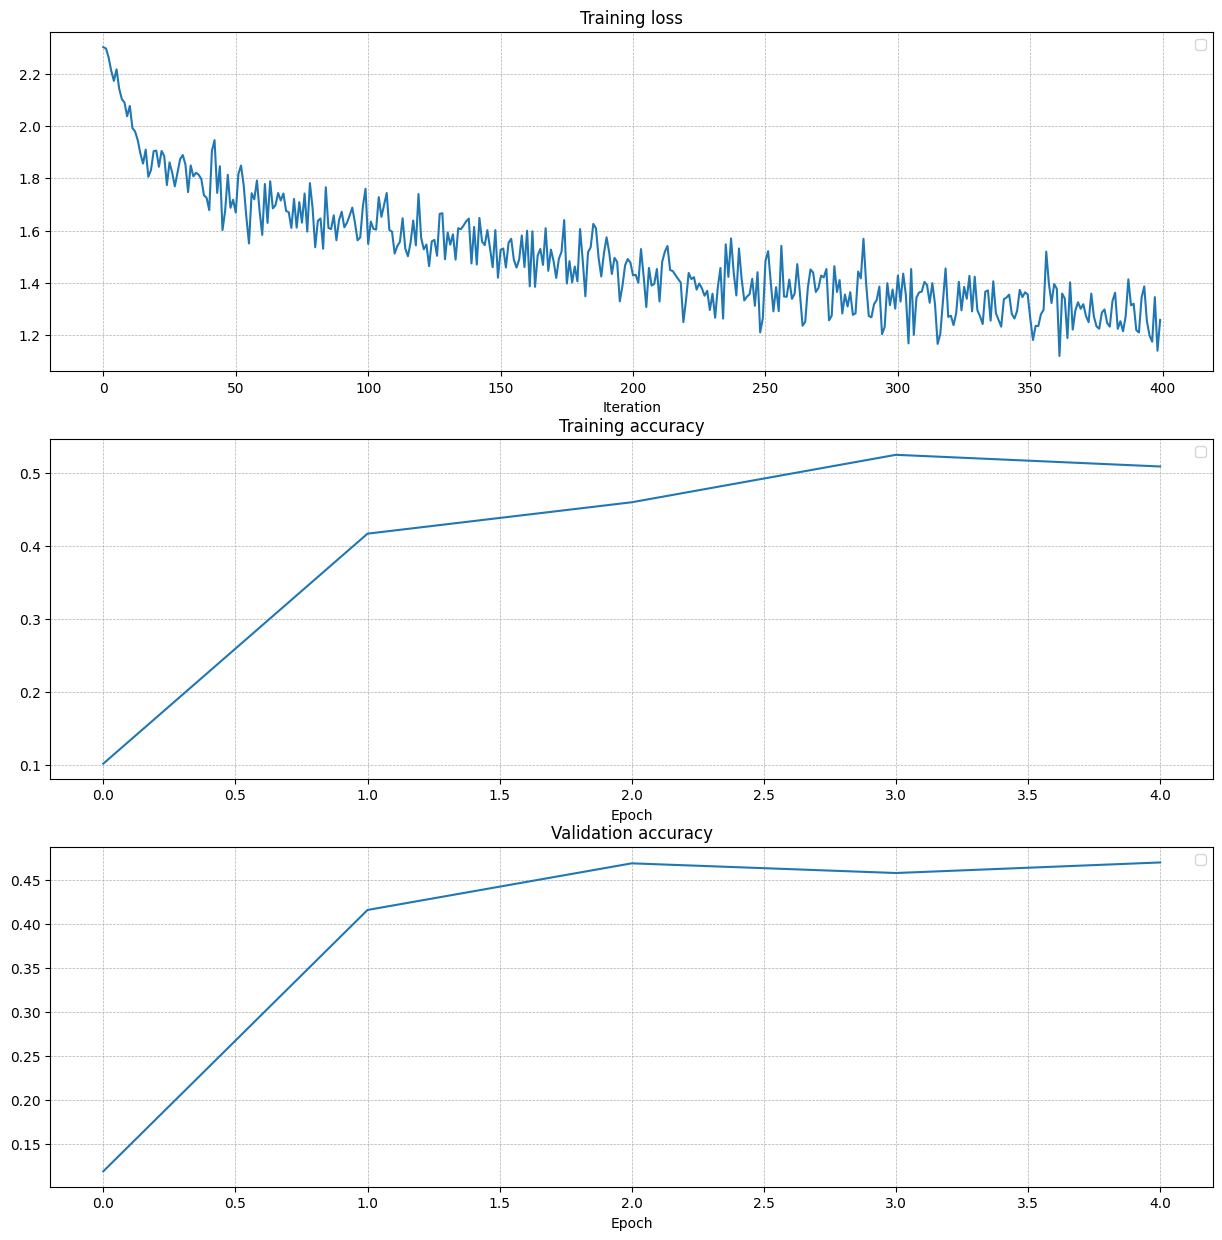

In [ ]:
from ml_dtypes import bfloat16

lr_list  = [2.1544346900318823e-03]                            #, 0.00015, 1e-7]
# lr_list  =        [2.1544346900318823e-05, 0.00014677992676220705, 0.00039811]

BEST_WSC = 0.003
reg_list = [0.0]              # , 0.1]             # reg_list = [0.0, 1.5, 3.14]

for LR in lr_list:
  for REG in reg_list:
    print("\n")
    model = FullyConnectedNet([100, 85, 50], weight_scale=BEST_WSC, normalization="batchnorm", reg=REG,  dtype=bfloat16)
    solver = Solver(model, some_data, update_rule='adam', optim_config = {'learning_rate': LR, "decay_rate": 0.95 },
                    num_epochs=4, batch_size=200, verbose=True)
    solver.train()

print("BEST VALID ACC: %f" % solver.best_val_acc)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

axes[0].plot(solver.loss_history)
axes[1].plot(solver.train_acc_history)
axes[2].plot(solver.val_acc_history)

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()



(Iteration 1 / 1225) loss: 2.300215
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.078000
(Iteration 11 / 1225) loss: 1.939723
(Iteration 21 / 1225) loss: 1.943072
(Iteration 31 / 1225) loss: 1.788779
(Iteration 41 / 1225) loss: 1.901585
(Iteration 51 / 1225) loss: 1.792343
(Iteration 61 / 1225) loss: 1.674833
(Iteration 71 / 1225) loss: 1.735735
(Iteration 81 / 1225) loss: 1.791882
(Iteration 91 / 1225) loss: 1.719139
(Iteration 101 / 1225) loss: 1.598064
(Iteration 111 / 1225) loss: 1.676966
(Iteration 121 / 1225) loss: 1.671093
(Iteration 131 / 1225) loss: 1.609497
(Iteration 141 / 1225) loss: 1.627581
(Iteration 151 / 1225) loss: 1.556195
(Iteration 161 / 1225) loss: 1.531677
(Iteration 171 / 1225) loss: 1.522610
(Iteration 181 / 1225) loss: 1.562694
(Iteration 191 / 1225) loss: 1.556679
(Iteration 201 / 1225) loss: 1.544793
(Iteration 211 / 1225) loss: 1.508795
(Iteration 221 / 1225) loss: 1.642676
(Iteration 231 / 1225) loss: 1.568966
(Iteration 241 / 1225) loss: 1.439035
(Epoch

/tmp/ipython-input-1330304306.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', ncol=4)


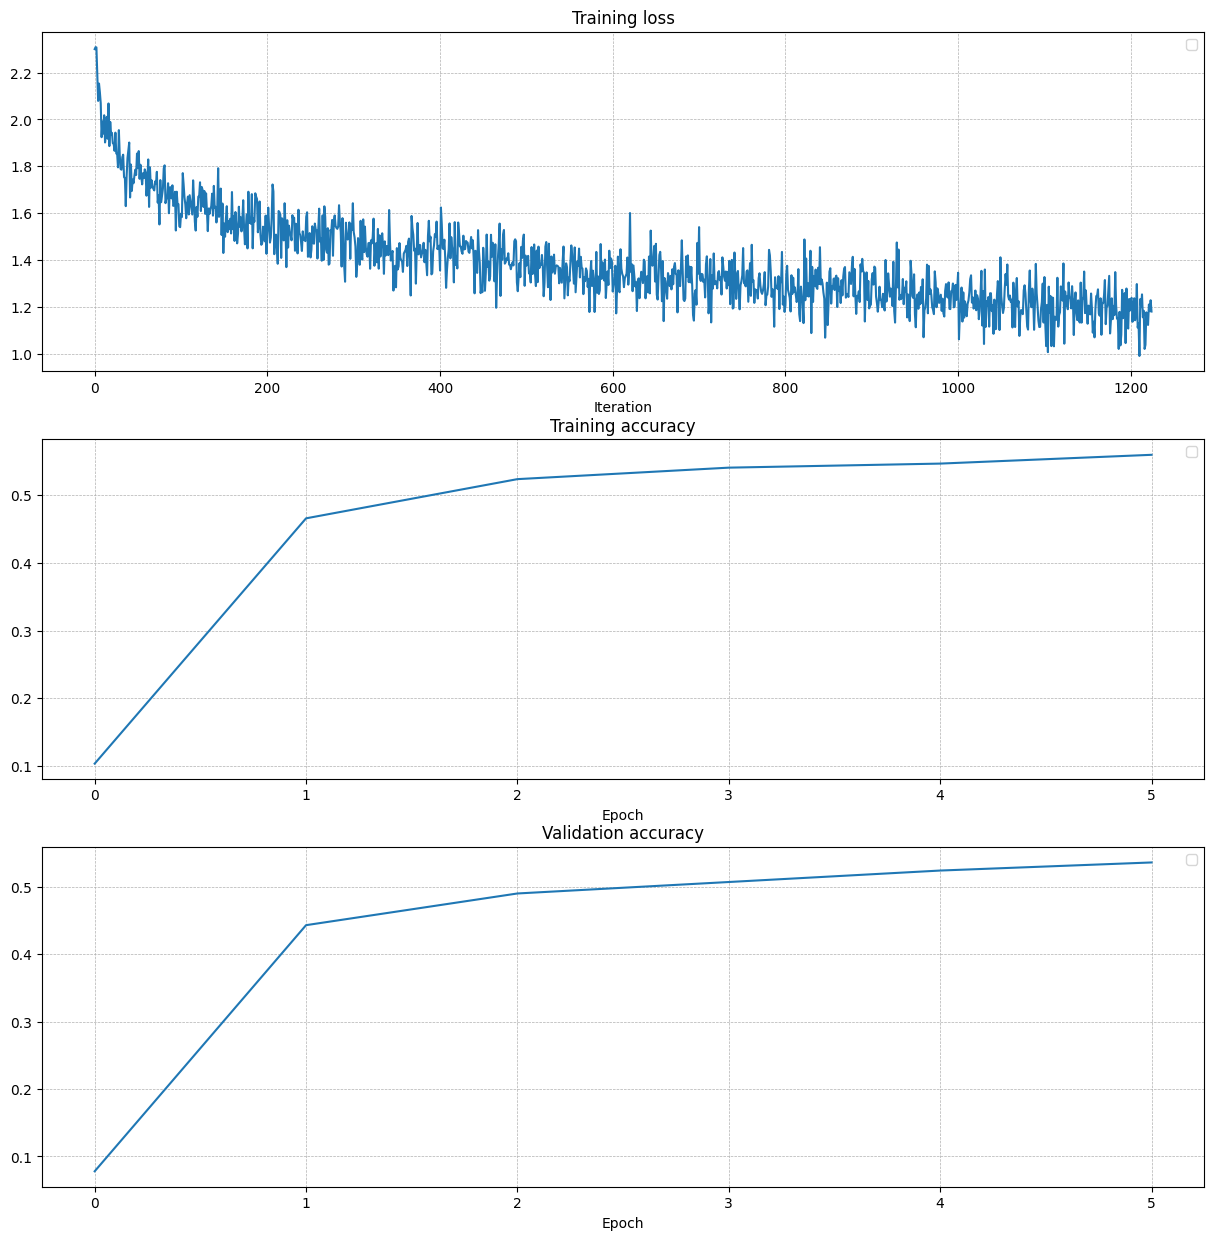

In [ ]:
from ml_dtypes import bfloat16

lr_list  = [5.1544346900318823e-03]                            #, 0.00015, 1e-7]
# lr_list  =        [2.1544346900318823e-05, 0.00014677992676220705, 0.00039811]

BEST_WSC = 0.003
reg_list = [0.0]              # , 0.1]             # reg_list = [0.0, 1.5, 3.14]

for LR in lr_list:
  for REG in reg_list:
    print("\n")
    model = FullyConnectedNet([100, 85, 50], weight_scale=BEST_WSC, normalization="batchnorm", reg=REG,  dtype=bfloat16)
    solver = Solver(model, data, update_rule='adam', optim_config = {'learning_rate': LR, "decay_rate": 0.95 },
                    num_epochs=5, batch_size=200, verbose=True)
    solver.train()

print("BEST VALID ACC: %f" % solver.best_val_acc)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

axes[0].plot(solver.loss_history)
axes[1].plot(solver.train_acc_history)
axes[2].plot(solver.val_acc_history)

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()